In [54]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from math import comb

# Inciso 1

## Complejidad de clases de hipótesis y función de crecimiento
- La **función de crecimiento** $\tau_{\mathcal H}(m)$ mide el número máximo de dicotomías que $\mathcal H$ puede tener sobre cualquier conjunto de $m$ puntos: $\tau_{\mathcal H}(m)=\max_{|C|=m}\| \mathcal H_C\|$. 
- Si $VCdim(\mathcal H)=d$, entonces para $m\le d$: $\tau_{\mathcal H}(m)=2^m$; y para $m>d$, **Sauer–Shelah–Perles** acota $\tau_{\mathcal H}(m)$ por $\sum_{i=0}^d \binom{m}{i}$.  
- **Ejemplos que estudiamos empíricamente** (Sección 6.3 del libro):  
  - **Umbrales en $\mathbb{R}$**: $VC=1$.  
  - **Intervalos en $\mathbb{R}$**: $VC=2$.   
  - **Separadores lineales** en $\mathbb{R}^d$: $VC=d+1$ (en particular, en $\mathbb{R}^2$ el $VC=3$). 
- DE modo que esta relación entre $VC$ y $\tau_{\mathcal H}$ se relaciona con lo de **aprendibilidad PAC** y **complejidad muestral** (Teorema fundamental): clases con $VC<\infty$ son PAC‐aprendibles y su muestra necesaria escala como $\tilde O\!\left(\frac{d+\log(1/\delta)}{\varepsilon^2}\right)$. 

---

## Cómo estimamos empíricamente $\tau_{\mathcal H}(m)$
Para cumplir la instrucción de que la **Parte 1 sea empírica**, estimamos $\tau_{\mathcal H}(m)$ con muchos conjuntos aleatorios de puntos y, para cada conjunto, computamos el máximo número de dicotomías que puede llegar a tener por la clase:
- En 1D (**umbrales** e **intervalos**), no tomamos umbrales al azar en el continuo: usamos el conjunto finito de candidatos críticos (puntos medios entre muestras y extremos) y todos los intervalos contiguos, que es lo que realiza el máximo. Esto evita sesgos de muestreo y hace que la curva empírica coincida con la teórica cuando corresponde (porque efectivamente maximizamos sobre $\mathcal H$). 
- En 2D , recorremos direcciones críticas (normales determinadas por pares de puntos) y umbrales en los puntos medios de las proyecciones; de nuevo, esto aproxima el “máximo sobre $\mathcal H$” de forma sistemática (no aleatoria continua).

---

## Por qué implementar “desde cero”
- El libro separa claramente el “qué” teórico (PAC/VC, crecimiento, ERM/SRM) del “**cómo**” computacional (cap. 8: implementar ERM; parte II: algoritmos). Reimplementar los bloques **ERM**, **perceptrón/halfspaces**, y las **rutinas de conteo de dicotomías** nos permite inspeccionar **casos límite**, **supuestos de posición general** y verificar empíricamente **límites de Sauer**.





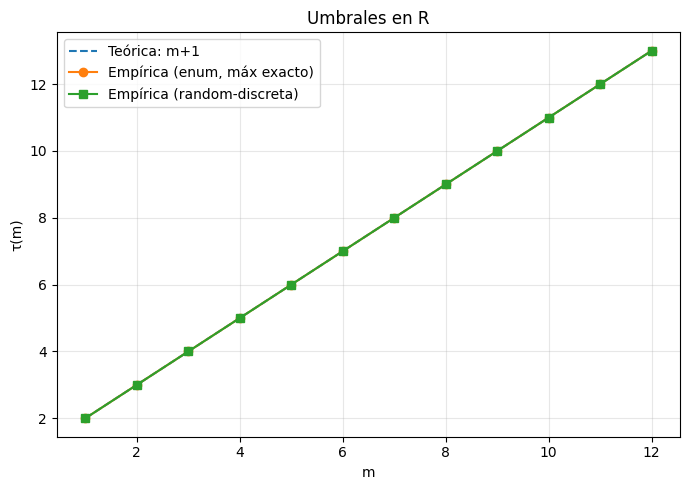

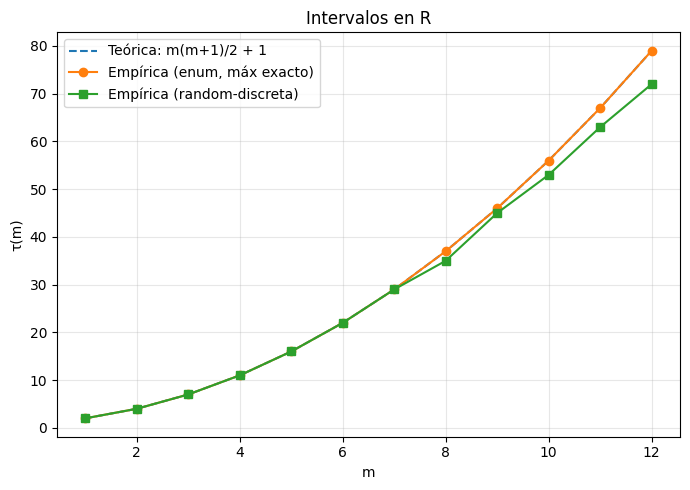

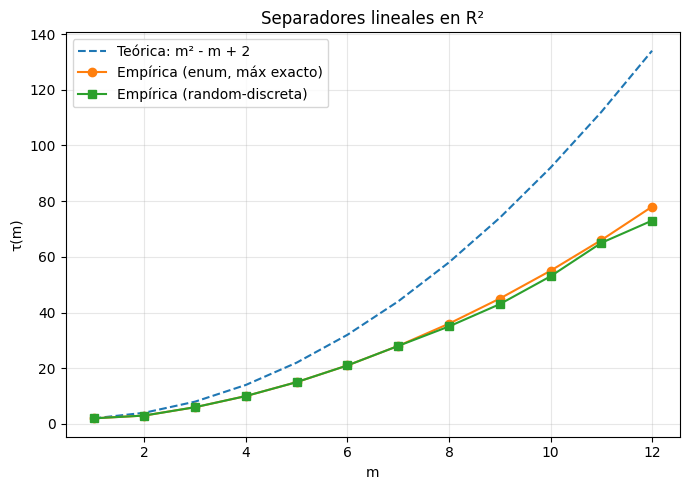

In [ ]:
# -*- coding: utf-8 -*-
import math
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)
# Funciones para calculos auxiliares
def uniq_bool(rows):
    return {tuple(r.tolist()) for r in rows}

def midpoints_between_sorted(vals):
    vals = np.asarray(vals, float)
    vals = np.unique(vals)
    mids = []
    if len(vals) == 0:
        return np.array([0.0])
    # extremos
    delta = (vals.max() - vals.min() + 1.0) if len(vals) > 1 else 1.0
    mids.append(vals.min() - delta)
    for i in range(1, len(vals)):
        mids.append(0.5*(vals[i-1] + vals[i]))
    mids.append(vals.max() + delta)
    return np.array(mids, float)

# Umbrales
def theo_thr(m):     
    return m + 1

def count_thr_enum(x):
    """Enumera TODOS los umbrales críticos (m+1)."""
    x = np.asarray(x, float)
    if len(np.unique(x)) < len(x):
        x = x + 1e-9 * rng.normal(size=len(x))
    thr = midpoints_between_sorted(np.sort(x))
    lab = [(x > t) for t in thr]
    return len(uniq_bool(np.vstack(lab)))

def count_thr_random_discrete(x, K):
    """
    Muestreo DISCRETO: elegir K umbrales del conjunto finito de (m+1) midpoints.
    Esto aproxima bien la cobertura y evita el 'despegue total'.
    """
    x = np.asarray(x, float)
    if len(np.unique(x)) < len(x):
        x = x + 1e-9 * rng.normal(size=len(x))
    mids = midpoints_between_sorted(np.sort(x))
    idx = rng.integers(0, len(mids), size=K)
    lab = [(x > mids[i]) for i in idx]
    return len(uniq_bool(np.vstack(lab)))

# Intervalos en R
def theo_int(m):
    return (m*(m+1))//2 + 1

def count_int_enum(x):
    """Enumera TODOS los bloques contiguos (más el vacío)."""
    x = np.asarray(x, float)
    if len(np.unique(x)) < len(x):
        x = x + 1e-9 * rng.normal(size=len(x))
    order = np.argsort(x)
    m = len(x)
    labs = [np.zeros(m, bool)]  
    y = np.zeros(m, bool)
    for i in range(m):
        for j in range(i, m):
            y[:] = False
            y[order[i:j+1]] = True
            labs.append(y.copy())
    return len(uniq_bool(np.vstack(labs)))

def count_int_random_discrete(x, K):
    """
    Muestreo DISCRETO: elegir K bloques contiguos eligiendo pares (i,j) uniformes.
    """
    x = np.asarray(x, float)
    if len(np.unique(x)) < len(x):
        x = x + 1e-9 * rng.normal(size=len(x))
    order = np.argsort(x)
    m = len(x)
    labs = []
    for _ in range(K):
        i = rng.integers(0, m)
        j = rng.integers(i, m)
        y = np.zeros(m, bool)
        y[order[i:j+1]] = True
        labs.append(y)
    if K > 0:
        labs.append(np.zeros(m, bool))
    return len(uniq_bool(np.vstack(labs)))

# Separadores lineales en R²
def theo_halfspaces_2d(m):
    # número máximo de dicotomías de separadores lineales en el plano, puntos en pos. general:
    # τ(m) = m^2 - m + 2 (y coincide con 2^m para m<=3)
    return m*m - m + 2

def critical_angles(P):
    """Ángulos perpendiculares a cada par (p_j - p_i); devolver ÁNGULOS MEDIOS (celdas)."""
    P = np.asarray(P, float)
    n = len(P)
    if n < 2:
        return np.array([0.0])
    angs = []
    for i in range(n):
        for j in range(i+1, n):
            v = P[j] - P[i]
            ang = math.atan2(v[1], v[0]) + math.pi/2.0
            ang = (ang % math.pi)
            angs.append(ang)
    angs = np.unique(np.array(angs))
    angs.sort()
    mids = []
    for k in range(len(angs)-1):
        mids.append(0.5*(angs[k] + angs[k+1]))
    wrap = (angs[-1] + angs[0] + math.pi) * 0.5
    wrap = wrap % math.pi
    mids.append(wrap)
    return np.array(mids)

def count_halfspace_enum(P):
    """Enumera todos los ángulos críticos y todos los umbrales de proyección."""
    P = np.asarray(P, float)
    P = P + 1e-10 * rng.normal(size=P.shape)
    angs = critical_angles(P)
    labs = set()
    for th in angs:
        u = np.array([math.cos(th), math.sin(th)])
        s = P @ u
        mids = midpoints_between_sorted(np.sort(s))
        for t in mids:
            labs.add(tuple((s > t).tolist()))
    return len(labs)

def count_halfspace_random_discrete(P, K):
    """
    Muestreo DISCRETO: elegir ángulos SOLO de la lista crítica, y umbral SOLO de midpoints.
    """
    P = np.asarray(P, float)
    P = P + 1e-10 * rng.normal(size=P.shape)
    angs = critical_angles(P)
    labs = []
    for _ in range(K):
        th = angs[rng.integers(0, len(angs))]
        u = np.array([math.cos(th), math.sin(th)])
        s = P @ u
        mids = midpoints_between_sorted(np.sort(s))
        t = mids[rng.integers(0, len(mids))]
        labs.append(s > t)
    return len(uniq_bool(np.vstack(labs)))

# Cálculo de K para buena cobertura
def k_for_coverage(M, p=0.9, mode="fraction"):
    """
    M = # de dicotomías posibles (tamaño del espacio finito).
    - mode='fraction': cobertura esperada ~ p  ->  K ≈ -M ln(1-p)
    - mode='full':    cobertura ~ 'casi todo'  ->  K ≈ M log M  (cupón-colector)
    """
    if M <= 1:
        return 1
    if mode == "full":
        return int(np.ceil(M * max(1.0, math.log(M))))
    # fraction
    p = min(max(p, 1e-6), 1-1e-6)
    return int(np.ceil(-M * math.log(1 - p)))

# Estimación empírica vs teórica
def estimate(M_max=12, trials=150, cov_target=0.9, mode="fraction"):
    m_vals = np.arange(1, M_max+1)

    th_thr = np.array([theo_thr(m) for m in m_vals])
    th_int = np.array([theo_int(m) for m in m_vals])
    th_lin = np.array([theo_halfspaces_2d(m) for m in m_vals])

    ee_thr = np.zeros_like(m_vals, int)  
    ee_int = np.zeros_like(m_vals, int)
    ee_lin = np.zeros_like(m_vals, int)

    er_thr = np.zeros_like(m_vals, int)   
    er_int = np.zeros_like(m_vals, int)
    er_lin = np.zeros_like(m_vals, int)

    for i, m in enumerate(m_vals):
        best_e_thr = best_e_int = best_e_lin = 0
        best_r_thr = best_r_int = best_r_lin = 0

        # K adaptativo por clase 
        K_thr = k_for_coverage(theo_thr(m), cov_target, mode)
        K_int = k_for_coverage(theo_int(m), cov_target, mode)
        K_lin = k_for_coverage(theo_halfspaces_2d(m), cov_target, mode)

        for _ in range(trials):
            x = rng.uniform(-1, 1, size=m)
            P = rng.uniform(-1, 1, size=(m, 2))
            # Exacto ENUMERATIVO
            best_e_thr = max(best_e_thr, count_thr_enum(x))
            best_e_int = max(best_e_int, count_int_enum(x))
            best_e_lin = max(best_e_lin, count_halfspace_enum(P))

            # Random DISCRETO 
            best_r_thr = max(best_r_thr, count_thr_random_discrete(x, K_thr))
            best_r_int = max(best_r_int, count_int_random_discrete(x, K_int))
            best_r_lin = max(best_r_lin, count_halfspace_random_discrete(P, K_lin))

        ee_thr[i], ee_int[i], ee_lin[i] = best_e_thr, best_e_int, best_e_lin
        er_thr[i], er_int[i], er_lin[i] = best_r_thr, best_r_int, best_r_lin

    return m_vals, (th_thr, th_int, th_lin), (ee_thr, ee_int, ee_lin), (er_thr, er_int, er_lin)

def plot_tripleta(title, m, theo, emp_e, emp_r, theo_label, fname):
    plt.figure(figsize=(7,5))
    plt.plot(m, theo,  '--', label=f'Teórica: {theo_label}')
    plt.plot(m, emp_e, '-o', label='Empírica (enum, máx exacto)')
    plt.plot(m, emp_r, '-s', label='Empírica (random-discreta)')
    plt.title(title); plt.xlabel('m'); plt.ylabel('τ(m)')
    plt.grid(True, alpha=.3); plt.legend(); plt.tight_layout()
    plt.savefig(fname, dpi=150)

if __name__ == "__main__":
    M_MAX  = 12
    TRIALS = 200
    MODE = "fraction"   
    Pcov = 0.9         

    m, th, ee, er = estimate(M_MAX, TRIALS, Pcov, MODE)
    th_thr, th_int, th_lin = th
    ee_thr, ee_int, ee_lin = ee
    er_thr, er_int, er_lin = er

    plot_tripleta("Umbrales en R", m, th_thr, ee_thr, er_thr, "m+1", "C2_umbrales.png")
    plot_tripleta("Intervalos en R", m, th_int, ee_int, er_int, "m(m+1)/2 + 1", "C2_intervalos.png")
    plot_tripleta("Separadores lineales en R²", m, th_lin, ee_lin, er_lin, "m² - m + 2", "C2_halfspaces.png")
    

# Inciso 2

In [55]:
np.set_printoptions(precision=4, suppress=True)


In [56]:
# Definimos una dataser pequeño y las funciones de ayuda 
xs = np.array([-3., -2., -1.,  0.,  1.,  2.], dtype=float)
ys = np.array([-1, -1,  1, -1, -1,  1], dtype=int)   # etiquetas en {-1,+1}

def zero_one_errors_threshold(xs, ys):
    """
    Para clasificadores umbral 1D: h_t(x) = +1 si x >= t, -1 en otro caso.
    Regresa candidatos de t (puntos medios) y errores 0-1 en cada candidato.
    """
    order = np.argsort(xs)
    xs_sorted = xs[order]
    ys_sorted = ys[order]
    candidates = [xs_sorted[0] - 1.0]
    for i in range(len(xs_sorted)-1):
        candidates.append((xs_sorted[i] + xs_sorted[i+1]) / 2.0)
    candidates.append(xs_sorted[-1] + 1.0)
    candidates = np.array(candidates, dtype=float)

    errs = []
    for t in candidates:
        pred = np.where(xs_sorted >= t, 1, -1)
        errs.append(int(np.sum(pred != ys_sorted)))
    return candidates, np.array(errs, dtype=int), xs_sorted, ys_sorted

def local_minima_indices(vals):
    """Índices de mínimos locales en una serie 1D (no estrictos)."""
    locs = []
    for i in range(1, len(vals)-1):
        if vals[i] <= vals[i-1] and vals[i] <= vals[i+1]:
            locs.append(i)
    return locs


## Inciso A : 0-1 con umbrales: múltiples mínimos locales

Candidatos t: [-4.  -2.5 -1.5 -0.5  0.5  1.5  3. ]
Errores 0-1 : [4 3 2 3 2 1 2]
Índices mínimos locales: [2, 5]
Índices mínimo(s) global(es): [5] con 1 errores


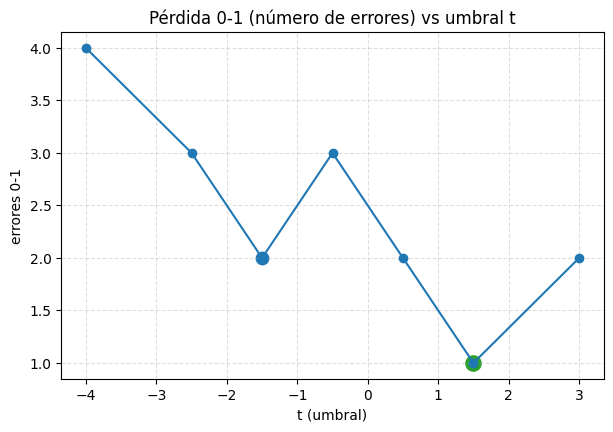

In [57]:
cand_t, errs_01, xs_sorted, ys_sorted = zero_one_errors_threshold(xs, ys)
loc_idxs = local_minima_indices(errs_01)
glob_min_err = errs_01.min()
glob_min_idxs = np.where(errs_01 == glob_min_err)[0]

print("Candidatos t:", cand_t)
print("Errores 0-1 :", errs_01)
print("Índices mínimos locales:", loc_idxs)
print("Índices mínimo(s) global(es):", glob_min_idxs.tolist(), "con", glob_min_err, "errores")

plt.figure(figsize=(7,4.5))
plt.plot(cand_t, errs_01, marker='o')
for i in loc_idxs:
    plt.scatter(cand_t[i], errs_01[i], s=80)
for i in glob_min_idxs:
    plt.scatter(cand_t[i], errs_01[i], s=120)
plt.title("Pérdida 0-1 (número de errores) vs umbral t")
plt.xlabel("t (umbral)")
plt.ylabel("errores 0-1")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

## Inciso B: 


Mínimo aproximado de L(b): b* ≈ -0.617, L(b*) ≈ 0.576


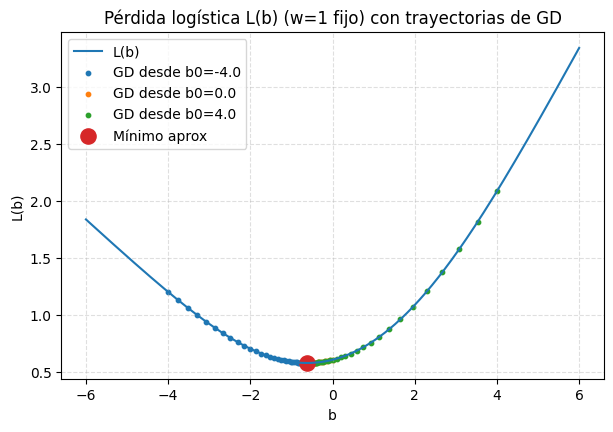

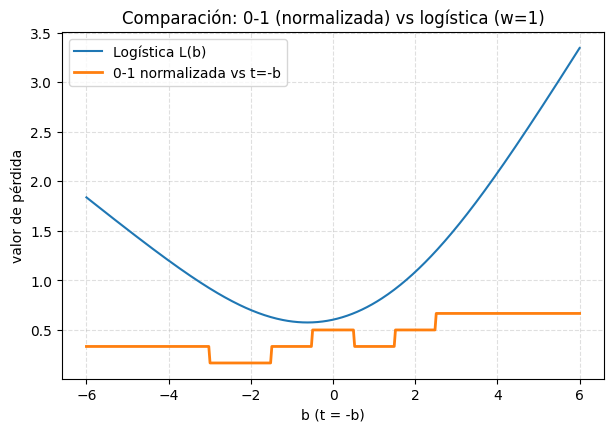

In [58]:
w_fixed = 1.0

def logistic_loss_b(b, xs, ys, w=1.0):
    # funcion de L(b) = mean log(1 + exp(-y*(w x + b)))
    z = w*xs + b
    return np.mean(np.log1p(np.exp(-ys*z)))

def logistic_grad_b(b, xs, ys, w=1.0):
    # funcion de grad = mean[ -y / (1 + exp(y z)) ]
    z = w*xs + b
    return np.mean(-ys / (1.0 + np.exp(ys*z)))

# Curva L(b)
b_vals = np.linspace(-6, 6, 400)
L_b = np.array([logistic_loss_b(b, xs, ys, w_fixed) for b in b_vals])
i_min = int(np.argmin(L_b))
b_star = float(b_vals[i_min])
L_star = float(L_b[i_min])
print(f"Mínimo aproximado de L(b): b* ≈ {b_star:.3f}, L(b*) ≈ {L_star:.3f}")

# Descenso de gradiente sobre b desde varios inicios
def gd_on_b(b0, xs, ys, w=1.0, lr=0.8, iters=40):
    traj_b = [b0]
    traj_L = [logistic_loss_b(b0, xs, ys, w)]
    b = b0
    for _ in range(iters):
        g = logistic_grad_b(b, xs, ys, w)
        b = b - lr*g
        traj_b.append(b)
        traj_L.append(logistic_loss_b(b, xs, ys, w))
    return np.array(traj_b), np.array(traj_L)

inits = [-4.0, 0.0, 4.0]
traj = [gd_on_b(b0, xs, ys, w_fixed, lr=0.8, iters=40) for b0 in inits]

plt.figure(figsize=(7,4.5))
plt.plot(b_vals, L_b, label="L(b)")
for (b_path, L_path), b0 in zip(traj, inits):
    plt.scatter(b_path, [logistic_loss_b(b, xs, ys, w_fixed) for b in b_path], s=10, label=f"GD desde b0={b0}")
plt.scatter([b_star], [L_star], s=120, label="Mínimo aprox")
plt.title("Pérdida logística L(b) (w=1 fijo) con trayectorias de GD")
plt.xlabel("b"); plt.ylabel("L(b)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()

# Comparación conceptual: 0-1 (normalizada) vs logística
n = len(xs)
t_from_b = -b_vals

def step_01_at_t(t):
    # error 0-1 normalizado evaluado como escalón en los candidatos
    idx = np.searchsorted(cand_t, t, side='right') - 1
    idx = int(np.clip(idx, 0, len(cand_t)-1))
    return errs_01[idx] / n

step_vals = np.array([step_01_at_t(t) for t in t_from_b])

plt.figure(figsize=(7,4.5))
plt.plot(b_vals, L_b, label="Logística L(b)")
plt.plot(b_vals, step_vals, label="0-1 normalizada vs t=-b", linewidth=2)
plt.title("Comparación: 0-1 (normalizada) vs logística (w=1)")
plt.xlabel("b (t = -b)"); plt.ylabel("valor de pérdida")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()

## C) GD en f(w)=$0.5*λ*w^2$: convergencia, oscilación y divergencia

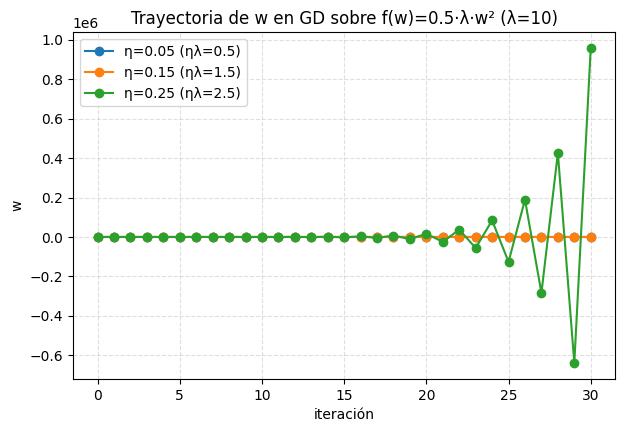

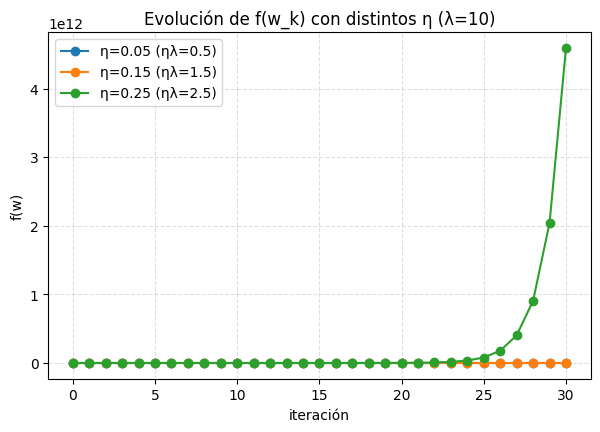

In [59]:
lam = 10.0

def f_quad(w): return 0.5 * lam * (w**2)
def grad_quad(w): return lam * w

def gd_quadratic(w0, lr, iters=30):
    ws = [w0]; fs = [f_quad(w0)]; w = w0
    for _ in range(iters):
        w = w - lr*grad_quad(w)
        ws.append(w); fs.append(f_quad(w))
    return np.array(ws), np.array(fs)

w0 = 5.0
lrs = [0.05, 0.15, 0.25]  # ηλ = 0.5 (converge), 1.5 (oscila y converge), 2.5 (oscila y diverge)
paths = [gd_quadratic(w0, lr, iters=30) for lr in lrs]

plt.figure(figsize=(7,4.5))
for (ws, fs), lr in zip(paths, lrs):
    plt.plot(range(len(ws)), ws, marker='o', label=f"η={lr} (ηλ={lr*lam:.1f})")
plt.title("Trayectoria de w en GD sobre f(w)=0.5·λ·w² (λ=10)")
plt.xlabel("iteración"); plt.ylabel("w")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()

plt.show()

plt.figure(figsize=(7,4.5))
for (ws, fs), lr in zip(paths, lrs):
    plt.plot(range(len(fs)), fs, marker='o', label=f"η={lr} (ηλ={lr*lam:.1f})")
plt.title("Evolución de f(w_k) con distintos η (λ=10)")
plt.xlabel("iteración"); plt.ylabel("f(w)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()


# Inciso 3

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

DEfinimos funciones que vamos a ocupar 

In [86]:
def fit_linear_min_norm(X, y, rcond=1e-12):
    """Solución de norma mínima por SVD (pseudoinversa): robusta en N>=D y N<D."""
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    if s.size == 0:
        return np.zeros(X.shape[1])
    tol = rcond * s.max()
    s_inv = np.zeros_like(s)
    s_inv[s > tol] = 1.0 / s[s > tol]
    return Vt.T @ (s_inv * (U.T @ y))

def smallest_nonzero_sigma(X, eps=1e-12):
    """Menor singular estrictamente > eps; si no hay, 0.0."""
    _, s, _ = np.linalg.svd(X, full_matrices=False)
    s_pos = s[s > eps]
    return float(np.min(s_pos)) if s_pos.size > 0 else 0.0

Parametros 

In [87]:
TEST_SIZE       = 0.30
RANDOM_STATE    = 123
REPS_PER_N      = 30          
STANDARDIZE_Y   = True # Usar unidades de desviación estándar en y

Datos

In [89]:
data   = load_diabetes()
X_all  = data.data.astype(float)    
y_all  = data.target.astype(float)  
X_tr_full, X_te_full, y_tr_full, y_te_full = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

n_full, D = X_tr_full.shape

Hacemos un barrido en el umbarl donde N aproxime a D y uno sobre N

In [90]:
low  = max(3, D - 6)
high = min(n_full - 1, D + 150)
N_grid = np.arange(low, high + 1)

# En N
rng = np.random.default_rng(RANDOM_STATE)

train_mse_mean, train_mse_std = [], []
test_mse_mean,  test_mse_std  = [], []
sigmin_mean,    sigmin_std    = [], []

for N in N_grid:
    mses_tr, mses_te, sigmins = [], [], []

    for _ in range(REPS_PER_N):
        idx  = rng.choice(X_tr_full.shape[0], size=N, replace=False)
        Xtr  = X_tr_full[idx]
        ytr  = y_tr_full[idx]

        scX   = StandardScaler()
        Xtr_s = scX.fit_transform(Xtr)
        Xte_s = scX.transform(X_te_full)

        if STANDARDIZE_Y:
            scY   = StandardScaler()
            ytr_s = scY.fit_transform(ytr.reshape(-1,1)).ravel()
            yte_s = scY.transform(y_te_full.reshape(-1,1)).ravel()
        else:
            ytr_s = ytr
            yte_s = y_te_full

        # Regresion 
        beta    = fit_linear_min_norm(Xtr_s, ytr_s)

        # Métricas
        yhat_tr = Xtr_s @ beta
        yhat_te = Xte_s @ beta
        mses_tr.append(mean_squared_error(ytr_s, yhat_tr))
        mses_te.append(mean_squared_error(yte_s, yhat_te))
        sigmins.append(smallest_nonzero_sigma(Xtr_s))

    train_mse_mean.append(np.mean(mses_tr))
    train_mse_std.append(np.std(mses_tr))
    test_mse_mean.append(np.mean(mses_te))
    test_mse_std.append(np.std(mses_te))
    sigmin_mean.append(np.mean(sigmins))
    sigmin_std.append(np.std(sigmins))

train_mse_mean = np.array(train_mse_mean)
train_mse_std  = np.array(train_mse_std)
test_mse_mean  = np.array(test_mse_mean)
test_mse_std   = np.array(test_mse_std)
sigmin_mean    = np.array(sigmin_mean)
sigmin_std     = np.array(sigmin_std)


Graficas 

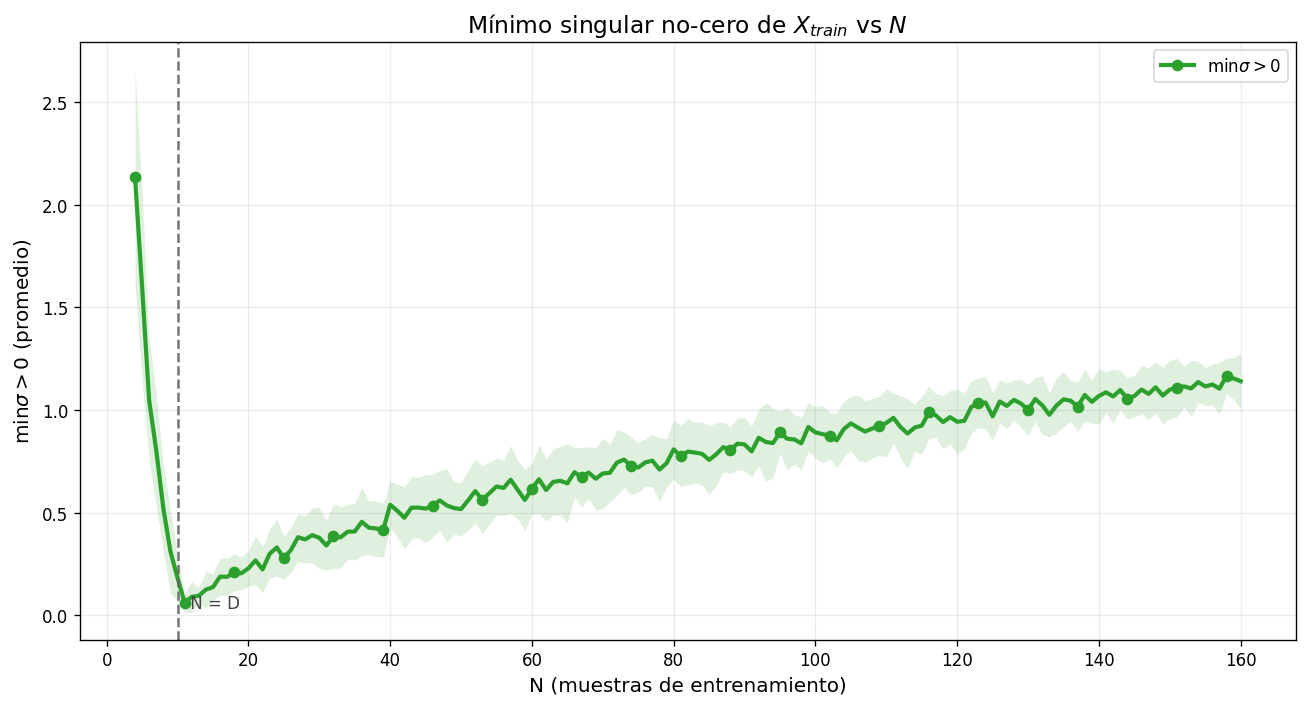

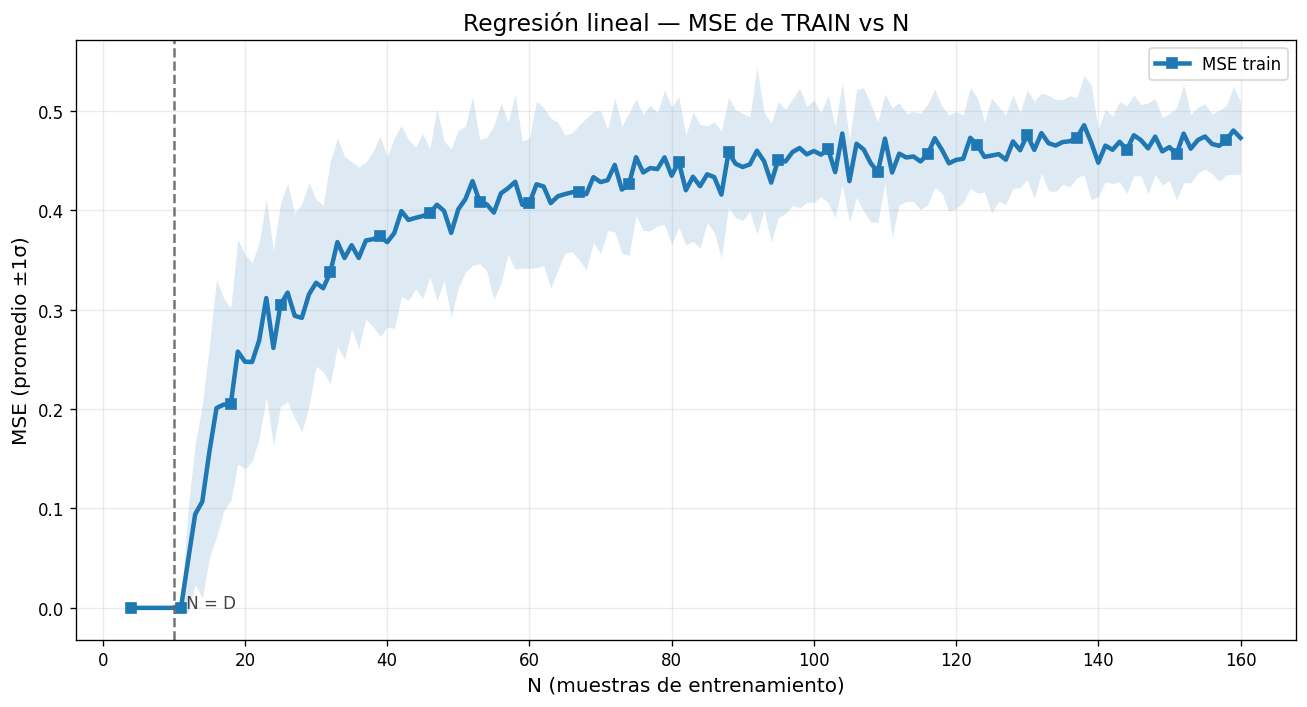

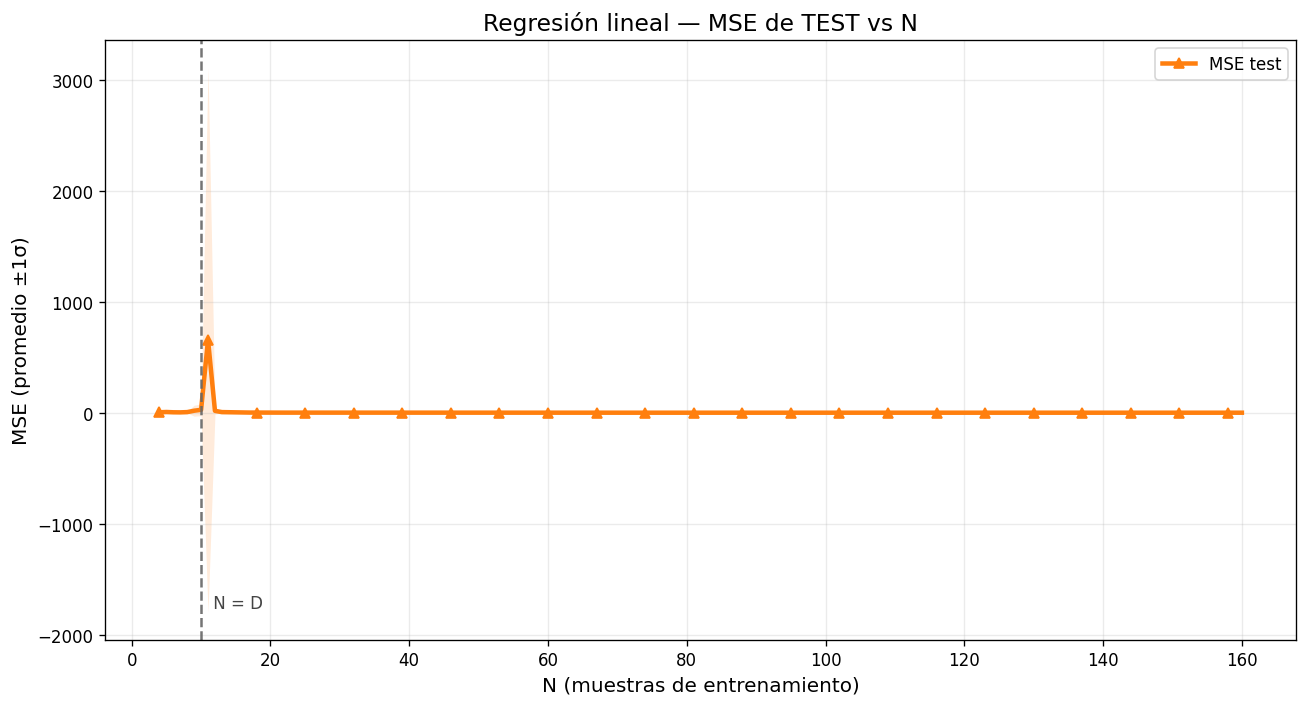

In [91]:
def draw_vline_N_equals_D(D, ymin, label=" N = D "):
    plt.axvline(D, color="#666666", linestyle="--", linewidth=1.5, alpha=0.9)
    plt.text(D + 1, ymin, label, color="#444444", va="bottom", ha="left")

# Fig 1
plt.figure(figsize=(11,6), dpi=120)
plt.title("Mínimo singular no-cero de $X_{train}$ vs $N$", fontsize=14)
plt.plot(N_grid, sigmin_mean, color="#2ca02c", marker="o",
         markevery=max(1, len(N_grid)//20), linewidth=2.5, label=r"$\min \sigma > 0$")
plt.fill_between(N_grid, sigmin_mean - sigmin_std, sigmin_mean + sigmin_std,
                 color="#2ca02c", alpha=0.15, linewidth=0)
ymin = float(np.nanmin(sigmin_mean - sigmin_std))
draw_vline_N_equals_D(D, ymin)
plt.xlabel("N (muestras de entrenamiento)", fontsize=12)
plt.ylabel(r"$\min \sigma > 0$ (promedio)", fontsize=12)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# Fig 2
plt.figure(figsize=(11,6), dpi=120)
plt.title("Regresión lineal — MSE de TRAIN vs N", fontsize=14)
plt.plot(N_grid, train_mse_mean, color="#1f77b4", marker="s",
         markevery=max(1, len(N_grid)//20), linewidth=2.7, label="MSE train")
plt.fill_between(N_grid, train_mse_mean - train_mse_std, train_mse_mean + train_mse_std,
                 color="#1f77b4", alpha=0.15, linewidth=0)
ymin = float(np.nanmin(train_mse_mean - train_mse_std))
draw_vline_N_equals_D(D, ymin)
plt.xlabel("N (muestras de entrenamiento)", fontsize=12)
plt.ylabel("MSE (promedio ±1σ)", fontsize=12)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# Fig 3
plt.figure(figsize=(11,6), dpi=120)
plt.title("Regresión lineal — MSE de TEST vs N", fontsize=14)
plt.plot(N_grid, test_mse_mean, color="#ff7f0e", marker="^",
         markevery=max(1, len(N_grid)//20), linewidth=2.7, label="MSE test")
plt.fill_between(N_grid, test_mse_mean - test_mse_std, test_mse_mean + test_mse_std,
                 color="#ff7f0e", alpha=0.15, linewidth=0)
ymin = float(np.nanmin(test_mse_mean - test_mse_std))
draw_vline_N_equals_D(D, ymin)
plt.xlabel("N (muestras de entrenamiento)", fontsize=12)
plt.ylabel("MSE (promedio ±1σ)", fontsize=12)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()